# (CS564 Machine Learning)Assignment 4 Solution
### by
## Saurabh Sharma(PhD Scholar)
## Roll No. 2021CS30

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB as Naive_Bayes
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate as cross_validation
from sklearn.utils._pprint import _EstimatorPrettyPrinter
import warnings
from sklearn import ensemble
from sklearn import model_selection
import inspect
import operator
from mpl_toolkits import mplot3d
%matplotlib inline
warnings.filterwarnings("ignore")        

# Taking Perkinson dataset for classification

In [2]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assg-4/ReplicatedAcousticFeatures-ParkinsonDatabase.csv')

## Preprocessing Part

In [3]:
# Dropping ID from analysis
data=data.drop('ID',axis=1)
data.head()

,Recording,Status,Gender,Jitter_rel,Jitter_abs,Jitter_RAP,Jitter_PPQ,Shim_loc,Shim_dB,Shim_APQ3,Shim_APQ5,Shi_APQ11,HNR05,HNR15,HNR25,HNR35,HNR38,RPDE,DFA,PPE,GNE,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,Delta0,Delta1,Delta2,Delta3,Delta4,Delta5,Delta6,Delta7,Delta8,Delta9,Delta10,Delta11,Delta12
0,1,0,1,0.25546,0.000015,0.001467,0.001673,0.030256,0.26313,0.017463,0.019660,0.021882,59.437966,60.736249,71.882864,77.626729,77.538042,0.250433,0.599346,0.005397,0.900404,1.319502,1.336201,1.302408,1.329085,1.284922,1.209225,1.239354,1.277002,1.332503,1.347470,1.367540,1.402141,1.393809,1.397874,1.372464,1.390298,1.407701,1.417218,1.380352,1.420670,1.451240,1.440295,1.403678,1.405495,1.416705,1.354610
1,2,0,1,0.36964,0.000022,0.001932,0.002245,0.023146,0.20217,0.013010,0.014097,0.016828,59.838895,62.655599,74.378669,79.989228,80.269783,0.271445,0.581242,0.075617,0.887042,1.215251,1.221557,1.265419,1.187177,1.256340,1.246375,1.283629,1.302498,1.308008,1.316527,1.370643,1.373966,1.344655,1.302399,1.347680,1.365750,1.331232,1.227338,1.213377,1.352739,1.354242,1.365692,1.322870,1.314549,1.318999,1.323508
2,3,0,1,0.23514,0.000013,0.001353,0.001546,0.019338,0.16710,0.011049,0.012683,0.013038,57.293808,61.858336,73.665297,78.930502,79.033510,0.203531,0.600759,0.005283,0.889399,1.426075,1.220701,1.344188,1.346296,1.339797,1.334447,1.391798,1.349621,1.349904,1.340463,1.362594,1.313769,1.277938,1.312889,1.352442,1.243385,1.412304,1.324674,1.276088,1.429634,1.455996,1.368882,1.438053,1.388910,1.305469,1.305402
3,1,0,0,0.29320,0.000017,0.001105,0.001444,0.024716,0.20892,0.014525,0.015696,0.018330,62.179573,68.678205,79.839984,84.367682,84.252430,0.261360,0.625216,0.030518,0.875984,1.495235,1.602983,1.572715,1.498323,1.561722,1.590510,1.626319,1.645811,1.666730,1.618487,1.493691,1.459040,1.383606,1.379629,1.217517,1.309647,1.501200,1.534170,1.323993,1.496442,1.472926,1.643177,1.551286,1.638346,1.604008,1.621456
4,2,0,0,0.23075,0.000015,0.001073,0.001404,0.013119,0.11607,0.006461,0.008385,0.011037,67.534024,74.976858,85.727420,91.033967,91.145189,0.222069,0.602493,0.035602,0.902206,1.516959,1.581687,1.542668,1.613747,1.501956,1.258557,1.385013,1.452518,1.498049,1.421549,1.557644,1.187218,1.576015,1.252247,1.577338,1.583072,1.508468,1.334511,1.610694,1.685021,1.417614,1.574895,1.640088,1.533666,1.297536,1.382023


# Taking Status for prediction

In [4]:
X=data.drop('Status',axis=1)
Y=data['Status']

# Taking 20% of overall dataset for study

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Taking Logistic regression, Naive Bayes & Decision Tree for Ensemble Classifier

In [6]:
c1= LogisticRegression(random_state=0)
c2= Naive_Bayes()
c3= DecisionTreeClassifier(max_depth=3, min_samples_split=2)

### Borrowed Function from sklearn for base estimator and accuracy score

In [7]:
class ClassifierMixin:
    def score(self, X, y, sample_weight=None):
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)

In [8]:
class BaseEstimator:
    def _get_param_names(cls):
        init = getattr(cls.__init__, 'deprecated_original', cls.__init__)
        if init is object.__init__:
            return []
        init_signature = inspect.signature(init)
        parameters = [p for p in init_signature.parameters.values()
                      if p.name != 'self' and p.kind != p.VAR_KEYWORD]
        return sorted([p.name for p in parameters])

    def get_params(self, deep=True):
        out = dict()
        for key in self._get_param_names():
          value = getattr(self, key)
          if deep and hasattr(value, 'get_params'):
            deep_items = value.get_params().items()
            out.update((key + '__' + k, val) for k, val in deep_items)
          out[key] = value
        return out

# Problem Statement
In this assignment you have to implement an Ensemble Classifier of Logistic regression, Naive Bayes & Decision Tree. The Goal is to implement a classification model to predict the “Status”feature in the provided Parkinson dataset.(Make sure to exclude the ID column). Make
necessary assumptions regarding hyperparameters. Construct the following -
1. Ensemble using Majority voting ;
2. Ensemble using weighted voting; accuracy of the classifiers on the development set
(20% of the overall data) is to be used as the weight.

# Implementing Both Voting Classifiers 
## Task 1. Ensemble using Majority voting ;
## Task 2. Ensemble using weighted voting; 
### 'weights' parameter provided as None by default
 If None, the majority rule voting will be applied to the predicted class labels.
 If a list of weights is given, the averaged raw probabilities will be used to determine the predicted class label.

In [9]:
class MyVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, weights=None):# For initialization purpose
        self.classifiers = classifiers
        self.weights = weights

    def fit(self, X, y):# Function to fit model
        for clf in self.classifiers:
            clf.fit(X, y)

    def predict(self, X):# Function to predict
        self.classes_new = np.asarray([clf.predict(X) for clf in self.classifiers])
        if self.weights:
            average = self.predict_proba(X)
            majority_class = np.apply_along_axis(lambda x: max(enumerate(x), key=operator.itemgetter(1))[0], axis=1, arr=average)# For Majority Voting
        else:
            majority_class = np.asarray([np.argmax(np.bincount(self.classes_new[:,c])) for c in range(self.classes_new.shape[1])])# For Weighted Voting
        return majority_class

    def predict_proba(self, X):
        self.probabilty_new = [clf.predict_proba(X) for clf in self.classifiers]
        average = np.average(self.probabilty_new, axis=0, weights=self.weights)
        return average

# Taking 20% data as weight
weights=[0.2,0.2,0.2]

In [10]:
eclfp = MyVotingClassifier(classifiers=[c1, c2, c3], weights=[0.2,0.2,0.2])#weighted voting
eclfm = MyVotingClassifier(classifiers=[c1, c2, c3])#majority voting
for clf, label in zip([c1, c2, c3, eclfm,eclfp], ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Majority Voting','Weighted Voting']):

    scores = model_selection.cross_val_score(clf, X_train, Y_train, cv=5, scoring='accuracy')
    print("Accuracy: %0.5f (+/- %0.5f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.75587 (+/- 0.06627) [Logistic Regression]
Accuracy: 0.84413 (+/- 0.06621) [Naive Bayes]
Accuracy: 0.77665 (+/- 0.06708) [Decision Tree]
Accuracy: 0.82321 (+/- 0.06958) [Majority Voting]
Accuracy: 0.82321 (+/- 0.06333) [Weighted Voting]


# Question A:
### For each of the ensembles compare the performance of the ensemble to each of the base models. Is there always a benefit of ensembles?

# Answer:
### Seeing the results, we can conclude that the ensemble technique is working better for this composition and dataset. But, after performing some different compositions in the same experiment, I found that sometimes individual base models performs better. So, there is not always benefit from the ensembles and also there will be time and space constraints.

# Trying with different weights and visualizing the table

In [11]:
df = pd.DataFrame(columns=('Logistic Regression Weight', 'Naive Bayes Weight', 'Decision Tree Weight', 'Mean Accuracy', 'Accuracy Standard Deviation','Accuracy Variance'))

p = 0
for wlr in range(1,4):
    for wnb in range(1,4):
        for wdt in range(1,4):

            if len(set((wlr,wnb,wdt))) == 1: #skipping equal weights
                continue

            eclf = MyVotingClassifier(classifiers=[c1, c2, c3], weights=[wlr,wnb,wdt])
            scores = model_selection.cross_val_score(
                                            estimator=eclf,
                                            X=X_train,
                                            y=Y_train,
                                            cv=5,
                                            scoring='accuracy',
                                            n_jobs=1)

            df.loc[p] = [wlr, wnb, wdt, scores.mean(), scores.std(),scores.var()]
            p += 1

df

,Logistic Regression Weight,Naive Bayes Weight,Decision Tree Weight,Mean Accuracy,Accuracy Standard Deviation,Accuracy Variance
0,1.0,1.0,2.0,0.791903,0.042000,0.001764
1,1.0,1.0,3.0,0.797301,0.056425,0.003184
2,1.0,2.0,1.0,0.844130,0.066209,0.004384
3,1.0,2.0,2.0,0.833603,0.052322,0.002738
4,1.0,2.0,3.0,0.791768,0.036070,0.001301
5,1.0,3.0,1.0,0.839001,0.076046,0.005783
6,1.0,3.0,2.0,0.833738,0.061182,0.003743
7,1.0,3.0,3.0,0.833603,0.052322,0.002738
8,2.0,1.0,1.0,0.833603,0.057373,0.003292
9,2.0,1.0,2.0,0.812821,0.058951,0.003475


# Some Data Visualization

Text(0.5, 0.92, '3d scatter plot for mean accuracy')

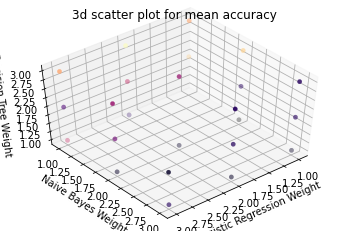

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = fig.gca(projection='3d')
ax.scatter(df['Logistic Regression Weight'],df['Naive Bayes Weight'],df['Decision Tree Weight'], c=df['Mean Accuracy'], cmap='magma_r',linewidths=0.2);
ax.view_init(50, 50)
ax.set_xlabel('Logistic Regression Weight')
ax.set_ylabel('Naive Bayes Weight')
ax.set_zlabel('Decision Tree Weight')
plt.title('3d scatter plot for mean accuracy')

Text(0.5, 0.92, '3d scatter plot for accuracy standard deviation')

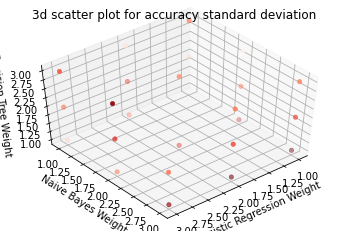

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = fig.gca(projection='3d')
ax.scatter(df['Logistic Regression Weight'],df['Naive Bayes Weight'],df['Decision Tree Weight'], c=df['Accuracy Standard Deviation'], cmap='Reds',linewidths=0.5);
ax.view_init(50, 50)
ax.set_xlabel('Logistic Regression Weight')
ax.set_ylabel('Naive Bayes Weight')
ax.set_zlabel('Decision Tree Weight')
plt.title('3d scatter plot for accuracy standard deviation')

Text(0.5, 0.92, '3d scatter plot for accuracy variance')

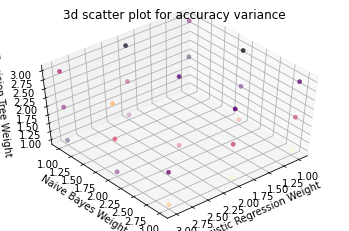

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = fig.gca(projection='3d')
ax.scatter(df['Logistic Regression Weight'],df['Naive Bayes Weight'],df['Decision Tree Weight'], c=df['Accuracy Variance'], cmap='magma',linewidths=0.2);
ax.view_init(50, 50)
ax.set_xlabel('Logistic Regression Weight')
ax.set_ylabel('Naive Bayes Weight')
ax.set_zlabel('Decision Tree Weight')
plt.title('3d scatter plot for accuracy variance')

Text(0.5, 0.92, '3d tri-surface plot for accuracy standard deviation')

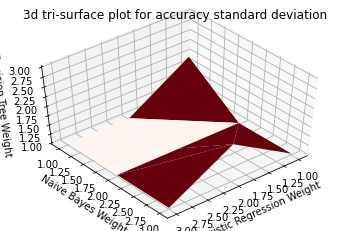

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['Logistic Regression Weight'],df['Naive Bayes Weight'],df['Decision Tree Weight'], triangles=df['Accuracy Standard Deviation'], cmap='Reds',linewidths=0.5);
ax.view_init(50, 50)
ax.set_xlabel('Logistic Regression Weight')
ax.set_ylabel('Naive Bayes Weight')
ax.set_zlabel('Decision Tree Weight')
plt.title('3d tri-surface plot for accuracy standard deviation')

Text(0.5, 0.92, '3d tri-surface plot for mean accuracy')

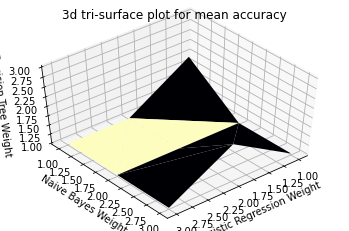

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['Logistic Regression Weight'],df['Naive Bayes Weight'],df['Decision Tree Weight'], triangles=df['Mean Accuracy'], cmap='magma_r',linewidths=0.5);
ax.view_init(50, 50)
ax.set_xlabel('Logistic Regression Weight')
ax.set_ylabel('Naive Bayes Weight')
ax.set_zlabel('Decision Tree Weight')
plt.title('3d tri-surface plot for mean accuracy')

Text(0.5, 0.92, '3d tri-surface plot for accuracy variance')

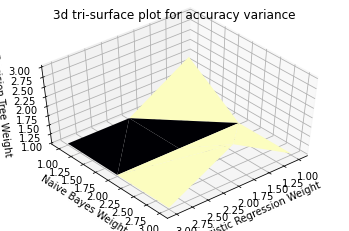

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['Logistic Regression Weight'],df['Naive Bayes Weight'],df['Decision Tree Weight'], triangles=df['Accuracy Variance'], cmap='magma',linewidths=0.5);
ax.view_init(50, 50)
ax.set_xlabel('Logistic Regression Weight')
ax.set_ylabel('Naive Bayes Weight')
ax.set_zlabel('Decision Tree Weight')
plt.title('3d tri-surface plot for accuracy variance')

# Question B:
### Redo ensemble with 5 versions of each of the specified classifiers(each version has different hyperparameters, if possible, for ex. For DT different versions can be generated by varying tree depth and branching factor, for logistic regression you can make variations by setting regularization etc.). How does this ensemble compare to the one with only one of each.


# Solution:

In [18]:
# Logistic regression with different regularizations
c11= LogisticRegression(random_state=0,penalty='l1')
c12= LogisticRegression(random_state=0,penalty='l2')
c13= LogisticRegression(random_state=0,penalty='elsticnet')
c14= LogisticRegression(random_state=0,penalty='none')
# Naive Bayes
c2= Naive_Bayes()
for i in range(1,4):#For different decision tree depths
    c3 = DecisionTreeClassifier(max_depth=i, min_samples_split=5)#For different max depths
    eclfp1 = MyVotingClassifier(classifiers=[c11, c2, c3], weights=[0.2,0.2,0.2])
    eclfm1 = MyVotingClassifier(classifiers=[c11, c2, c3])
    eclfp2 = MyVotingClassifier(classifiers=[c12, c2, c3], weights=[0.2,0.2,0.2])
    eclfm2 = MyVotingClassifier(classifiers=[c12, c2, c3])
    eclfp3 = MyVotingClassifier(classifiers=[c13, c2, c3], weights=[0.2,0.2,0.2])
    eclfm3 = MyVotingClassifier(classifiers=[c13, c2, c3])
    eclfp4 = MyVotingClassifier(classifiers=[c14, c2, c3], weights=[0.2,0.2,0.2])
    eclfm4 = MyVotingClassifier(classifiers=[c14, c2, c3])
    print("For decision tree depth %d: " % (i))
    print("Logistic regression using L1- Regularization:")
    for clf, label in zip([c11, c2, c3, eclfm1,eclfp1], ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Majority Voting','Weighted Voting']):
      scores = model_selection.cross_val_score(clf, X_train, Y_train, cv=5, scoring='accuracy')
      print("Accuracy: %0.5f (+/- %0.5f) [%s] " % (scores.mean(), scores.std(), label))
    print("Logistic regression using L2- Regulrization:")
    for clf, label in zip([c12, c2, c3, eclfm2,eclfp2], ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Majority Voting','Weighted Voting']):
      scores = model_selection.cross_val_score(clf, X_train, Y_train, cv=5, scoring='accuracy')
      print("Accuracy: %0.5f (+/- %0.5f) [%s] " % (scores.mean(), scores.std(), label))
    print("Logistic regression using elasticnet- Regulrization:")
    for clf, label in zip([c13, c2, c3, eclfm3,eclfp3], ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Majority Voting','Weighted Voting']):
      scores = model_selection.cross_val_score(clf, X_train, Y_train, cv=5, scoring='accuracy')
      print("Accuracy: %0.5f (+/- %0.5f) [%s] " % (scores.mean(), scores.std(), label))
    print("Logistic regression using no Regulrization:")
    for clf, label in zip([c14, c2, c3, eclfm4,eclfp4], ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Majority Voting','Weighted Voting']):
      scores = model_selection.cross_val_score(clf, X_train, Y_train, cv=5, scoring='accuracy')
      print("Accuracy: %0.5f (+/- %0.5f) [%s] " % (scores.mean(), scores.std(), label))

For decision tree depth 1: 
Logistic regression using L1- Regularization:
Accuracy: nan (+/- nan) [Logistic Regression] 
Accuracy: 0.84413 (+/- 0.06621) [Naive Bayes] 
Accuracy: 0.72942 (+/- 0.03325) [Decision Tree] 
Accuracy: nan (+/- nan) [Majority Voting] 
Accuracy: nan (+/- nan) [Weighted Voting] 
Logistic regression using L2- Regulrization:
Accuracy: 0.75587 (+/- 0.06627) [Logistic Regression] 
Accuracy: 0.84413 (+/- 0.06621) [Naive Bayes] 
Accuracy: 0.72942 (+/- 0.03325) [Decision Tree] 
Accuracy: 0.81296 (+/- 0.07470) [Majority Voting] 
Accuracy: 0.84413 (+/- 0.05297) [Weighted Voting] 
Logistic regression using elasticnet- Regulrization:
Accuracy: nan (+/- nan) [Logistic Regression] 
Accuracy: 0.84413 (+/- 0.06621) [Naive Bayes] 
Accuracy: 0.72942 (+/- 0.03325) [Decision Tree] 
Accuracy: nan (+/- nan) [Majority Voting] 
Accuracy: nan (+/- nan) [Weighted Voting] 
Logistic regression using no Regulrization:
Accuracy: 0.75560 (+/- 0.04865) [Logistic Regression] 
Accuracy: 0.84413 

# Answer:
### From the results, it can be clearly seen that Logistic regression with L1 and elastic net regularization doesn't work well. So, the results can be compared for L2 and no regularization. For L2- regularization, the ensemble methods are giving mixed results(sometimes better and sometimes worse) on changing the max-depths. But, with no regularization, ensemble methods are giving bad results.

# End of Assignment and all the tasks